Importar librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
pip install pyarrow

^C
Note: you may need to restart the kernel to use updated packages.


# Analisis de Churn para empresa de e-commerce

## Objetivo:

¿Cuántas personas llenan el carrito de la compra de un e-commerce y se van sin comprar nada? ¿Por qué es importante conocer esta métrica? ¿Cómo conseguir que compren los artículos en los que se habían interesado?

La tasa de abandono de los carritos, también conocida como Churn Rate, es uno de los datos más importantes en el análisis de un e-commerce, ya que nos informa del porcentaje de personas que se interesan por alguno de nuestros productos, pero finalmente no realiza ninguna conversión.
Para calcularlo matemáticamente debemos poner en marcha la siguiente métrica

Tasa de abandono del carrito = (Número de visitas que han añadido al menos un producto al carrito y no han comprado / Total de visitas que han añadido al menos un producto al carrito) x 100

## Lectura del dataset

In [5]:
df = pd.read_parquet('data-ecomm-10-19-smallsampled.parquet', engine='pyarrow')

In [17]:
df = pd.read_parquet('/content/drive/MyDrive/Diplomatura Data Science/datasets/data-ecomm-10-19-smallsampled.parquet', engine='pyarrow')

## Recolección de datos y primer análisis

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
39054315,2019-10-29 07:06:41 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba
2640418,2019-10-03 06:05:30 UTC,view,26020177,2053013562644759347,None,None,9.050,529412421,0ee743f2-1a41-4e6f-8d8e-cd38135032a0
24303444,2019-10-18 14:21:55 UTC,view,1307059,2053013558920217191,computers.notebook,apple,1569.920,549727626,022640cb-f45a-4e76-9ade-3eeec65d7837
16337102,2019-10-13 08:46:22 UTC,view,12709948,2053013553559896355,None,triangle,36.940,550305198,56ef2383-4c9d-4475-adcd-d4eeb4205fde
41227753,2019-10-31 02:05:01 UTC,view,1005160,2053013555631882655,electronics.smartphone,xiaomi,212.120,535374900,a4ee5bfa-3824-4f66-87fb-0d0ae358f307


In [7]:
df['event_type'].value_counts(normalize=True)

view       0.921
purchase   0.040
cart       0.039
Name: event_type, dtype: float64

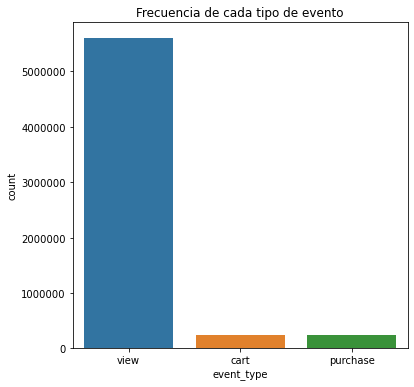

In [8]:
fig, ax = plt.subplots(figsize = (6, 6))
sns.set_context("notebook")
sns.countplot(x="event_type", data=df)
ax.set_title('Frecuencia de cada tipo de evento')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)


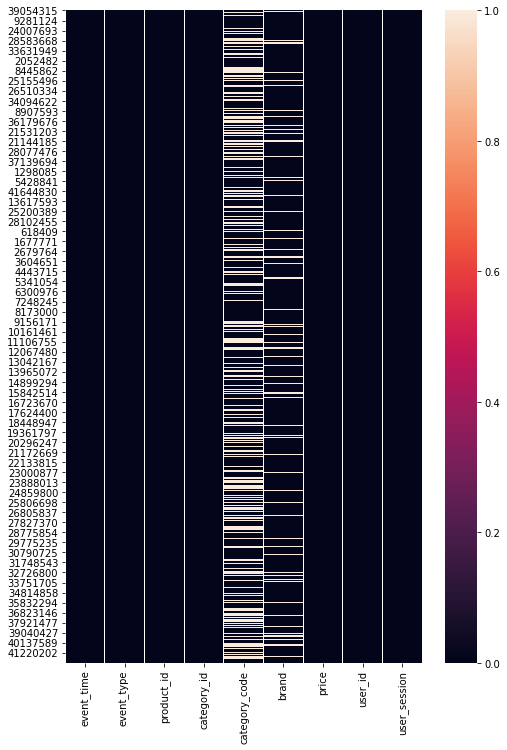

In [ ]:
fig, ax = plt.subplots(figsize = (8, 12))
ax = sns.heatmap(df.isnull())

In [9]:
df.groupby('event_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
cart,237171.000,335.177,350.372,0.000,130.990,197.120,398.770,2574.040
purchase,241594.000,309.106,349.393,0.790,87.260,179.260,373.210,2574.070
view,5605452.000,276.465,346.521,0.000,61.780,154.160,334.340,2574.070


Text(0.5, 1.0, 'Histograma de precio')

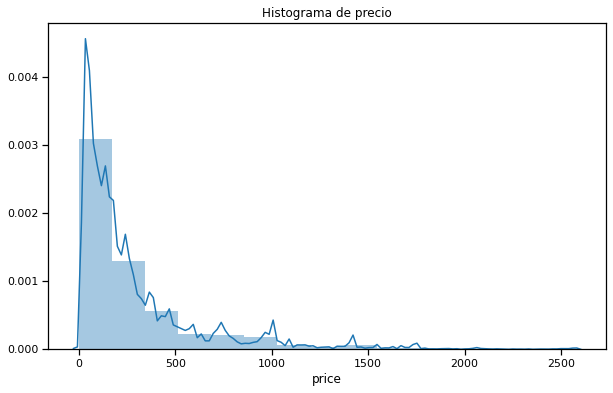

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.distplot(df['price'],bins=15, hist=True, kde=True)
ax.set_title('Histograma de precio') # están concentrados entre 0 y 250 mas o menos

In [11]:
usuarios = df['user_id']
usuarios.nunique()

1028553

In [12]:
id_compradores = df[df['event_type'] == 'purchase']['user_id']
id_compradores.nunique() 

124354

In [13]:
# porcentaje de usuarios que compran
(id_compradores.nunique()/usuarios.nunique())*100
# solo el 12% de los usuarios de la página de e-commerce realizaron alguna compra

12.090188838105572

In [14]:
df['category_code'].nunique()

126

In [15]:
codigos_vendidos = df[df['event_type'] == 'purchase']['category_code']
codigos_vendidos.nunique() 

116

In [16]:
# porcentaje de códigos que son vendidos
(codigos_vendidos.nunique()/df['category_code'].nunique())*100
# el 92% de los códigos de la página de e-commerce son vendidos

92.06349206349206

In [17]:
df['category_id'].nunique()

614

In [18]:
categorias_vendidas = df[df['event_type'] == 'purchase']['category_id']
categorias_vendidas.nunique() 

#¿Podemos borrar las que no son vendidas? buscar su nombre como para saberlas 

538

In [19]:
# porcentaje de categorías que son vendidas
(categorias_vendidas.nunique()/df['category_id'].nunique())*100
# solo el 87% de las categorías de la página de e-commerce son vendidas

87.62214983713355

In [20]:
ventas = df[df['event_type'] == 'purchase']
len(ventas)
# de todos los datos, solo 241mil fueron compras, por 124mil usuarios distintos

241594

## Tratamiento de duplicados

In [22]:
df.duplicated().sum()

5990

In [23]:
df.drop_duplicates(inplace=True)

## Métodos para tratamiento de datos

In [24]:
# método de para tratamiento de fechas de fechas
def process_event_time(df, time_format='%Y-%m-%d %H:%M:%S UTC'):
    df['event_time'] = pd.to_datetime(df['event_time'], format = time_format)
    df['day_of_week'] = df.event_time.dt.day_name()   
    df['date'] = df.event_time.dt.date
    df['time'] = df.event_time.dt.time
    df = df.drop(columns='event_time') #no lo uso con inplace porque me puede afectar la variable global df 
    return df

In [25]:
df_preprocessed = process_event_time(df)

## Tratamiento de datos

nulos: 
- heatmap(df.isnull()) para ver la distribución por columna
- eliminar los productos gratis 
- eliminar aquellas vistas con category code nulos
- category code nulos restantes, reemplazarlos según el product id, después asignarles una categoría por defecto y ver su frecuencia. Eliminar los no relevantes.


variables:
- dejar solo categorias y productos que representen hasta un 1%
- pasar a datetime los que se necesiten

### Tratamiento de nulos

Category code

In [26]:
df_preprocessed[df_preprocessed.category_code.isna()]['event_type'].value_counts(normalize=True)

view       0.958
purchase   0.030
cart       0.013
Name: event_type, dtype: float64

In [27]:
df_preprocessed[df_preprocessed.category_code.isna()]['event_type'].value_counts()

view        1832785
purchase      56488
cart          24635
Name: event_type, dtype: int64

Como nuestro objetivo es analizar la incidencia entre carrito --> compra, decidimos borrar las vistas que no poseen categoría. 

In [28]:
view_ccode_nan = df_preprocessed.loc[(df_preprocessed['event_type'] == 'view') & (df_preprocessed.category_code.isna())]

In [29]:
df_preprocessed.drop(view_ccode_nan.index, inplace=True)

Para analizar las NaN restantes entre carrito y compra les asignamos valores. 
- Selección por id único (3 primeros n° de product_id) con las no NaN coincidentes
- Selección por id único, pero con el n° por defecto, no con un nombre

Luego verificamos la frecuencia de cada uno para dejar solo los que representen al menos 1% del total.

In [30]:
df_preprocessed['cat_code'] = df_preprocessed['product_id'].astype(str).str[:3]

In [31]:
newdf = df_preprocessed[['cat_code','category_code']].copy()
newdf = newdf.set_index('cat_code')
newdf = newdf.dropna().drop_duplicates()
cat_codes_dict = newdf['category_code'].to_dict()
df_preprocessed['category_code'].fillna(df_preprocessed['cat_code'].map(cat_codes_dict),inplace=True)

In [32]:
df_preprocessed['category_code'].isnull().sum()

71943

In [33]:
df_test = df_preprocessed.copy() # en un df de prueba hacemos la carga de n° para ver la frecuencia

In [34]:
df_test.loc[pd.isna(df_preprocessed["category_code"]), "category_code"] = df_test[pd.isna(df_test["category_code"])]["cat_code"]

In [35]:
df_test['category_code'].value_counts(normalize=True)[:15]

electronics.smartphone             0.404
electronics.clocks                 0.045
electronics.audio.headphone        0.040
electronics.video.tv               0.038
computers.notebook                 0.037
appliances.kitchen.washer          0.030
appliances.kitchen.refrigerators   0.028
appliances.environment.vacuum      0.028
apparel.shoes                      0.024
auto.accessories.player            0.015
computers.desktop                  0.013
apparel.shoes.keds                 0.012
electronics.audio.subwoofer        0.011
electronics.tablet                 0.011
furniture.bedroom.bed              0.010
Name: category_code, dtype: float64

Vemos que en las categorías más frecuentes no hay presente ninguno de estos valores NaN, entonces decidimos borrarlas en nuestro df_preprocessed.

In [36]:
df_preprocessed.drop(df_preprocessed[df_preprocessed['category_code'].isna()].index, inplace=True)

In [37]:
df_preprocessed.shape[0]

4173499

In [88]:
df['event_type'].value_counts(normalize=True)

view       0.922
purchase   0.040
cart       0.038
Name: event_type, dtype: float64

In [38]:
df_preprocessed['event_type'].value_counts(normalize=True)

view       0.904
cart       0.051
purchase   0.045
Name: event_type, dtype: float64

En conclusión, eliminamos en un primer momento los datos nulos correspondientes a views ya que representan la mayoría de los nulos y no influyen en nuestro objetivo. Corroborando, vemos que al principio las views representan un 92% de los datos, compras y carrito el 4% cada uno. Luego del analisis y eliminación las views representan 90%, los carritos 5% y las compras 4,5%.

(array([[3772532.,       0.,       0.,       0.,       0.,  211929.,
               0.,       0.,       0.,  189038.],
        [5605317.,       0.,       0.,       0.,       0.,  231338.,
               0.,       0.,       0.,  241572.]]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 2 BarContainer objects>)

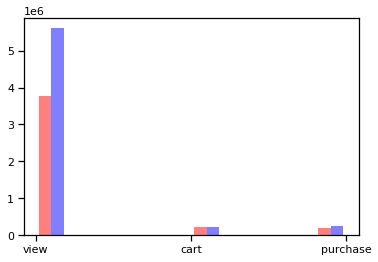

In [111]:
y=df['event_type'].to_numpy()
x=df_preprocessed['event_type'].to_numpy()
plt.hist([x,y] , color=['r','b'], alpha=0.5)

In [62]:
preprocesado = pd.Series(df_preprocessed['event_type']).value_counts()
original = pd.Series(df['event_type']).value_counts()

#get the counts as a dataframe
df1=pd.concat([preprocesado,original],axis=1)
df1.columns=['preprocesado','original']

# melt the data frame so it has a "tidy" data format
df1=df1.reset_index().melt(id_vars=['index'])
df1

,index,variable,value
0,view,preprocesado,3772532
1,cart,preprocesado,211929
2,purchase,preprocesado,189038
3,view,original,5605317
4,cart,original,231338
5,purchase,original,241572


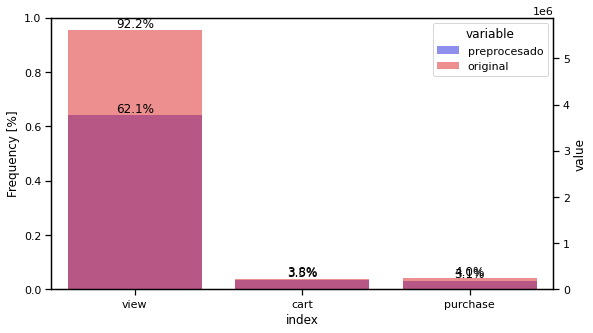

In [70]:
#plot a bar graph and assign variable to hue
ncount = len(df)
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(
    x='index',
    y='value',
    hue='variable',
    data=df1,
    palette=['blue','red'],
    alpha=.5,
    dodge=False)

# Make twin axis
ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')


ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text


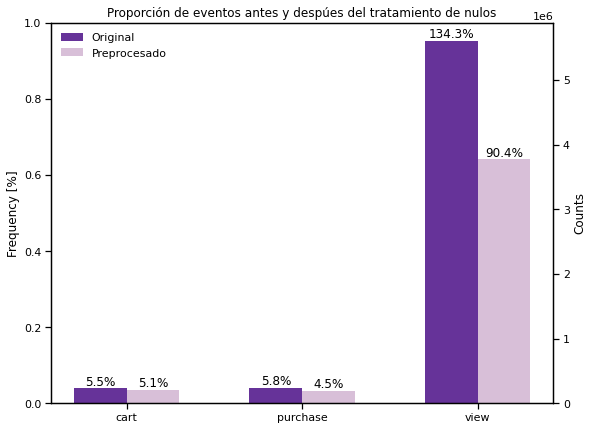

In [112]:
first_list = df["event_type"]
second_list = df_preprocessed["event_type"]

# Create dictionaries from lists with this format: 'letter':count
dict1 = dict(zip(*np.unique(first_list, return_counts=True)))
dict2 = dict(zip(*np.unique(second_list, return_counts=True)))

# Add missing letters with count=0 to each dictionary so that keys in
# each dictionary are identical
only_in_set1 = set(dict1)-set(dict2)
only_in_set2 = set(dict2)-set(dict1)
dict1.update(dict(zip(only_in_set2, [0]*len(only_in_set2))))
dict2.update(dict(zip(only_in_set1, [0]*len(only_in_set1))))

# Sort dictionaries alphabetically
dict1 = dict(sorted(dict1.items()))
dict2 = dict(sorted(dict2.items()))

# Create grouped bar chart
xticks = np.arange(len(dict1))
bar_width = 0.3
fig, ax = plt.subplots(figsize=(9, 7))
ax.bar(xticks-bar_width/2, dict1.values(), bar_width,
       color='rebeccapurple', label='Original')
ax.bar(xticks+bar_width/2, dict2.values(), bar_width,
       color='thistle', label='Preprocesado')

# Set annotations, x-axis ticks and tick labels
ax.set_ylabel('Counts')
ax.set_title('Proporción de eventos antes y despúes del tratamiento de nulos')
ax.set_xticks(xticks)
ax.set_xticklabels(dict1.keys())
ax.legend(frameon=False)

# Percentage labels
ncount = len(df_preprocessed)
# Make twin axis
ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

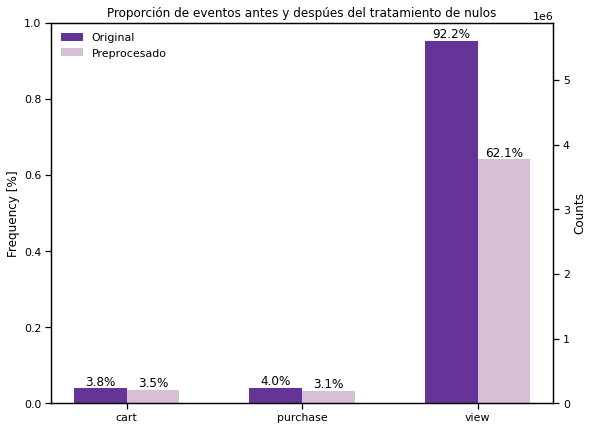

In [98]:
first_list = df["event_type"]
second_list = df_preprocessed["event_type"]

# Create dictionaries from lists with this format: 'letter':count
dict1 = dict(zip(*np.unique(first_list, return_counts=True)))
dict2 = dict(zip(*np.unique(second_list, return_counts=True)))

# Create grouped bar chart
xticks = np.arange(len(dict1))
bar_width = 0.3
fig, ax = plt.subplots(figsize=(9, 7))
ax.bar(xticks-bar_width/2, dict1.values(), bar_width,
       color='rebeccapurple', label='Original')
ax.bar(xticks+bar_width/2, dict2.values(), bar_width,
       color='thistle', label='Preprocesado')

# Set annotations, x-axis ticks and tick labels
ax.set_ylabel('Counts')
ax.set_title('Proporción de eventos antes y despúes del tratamiento de nulos')
ax.set_xticks(xticks)
ax.set_xticklabels(dict1.keys())
ax.legend(frameon=False)

# Make twin axis
ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

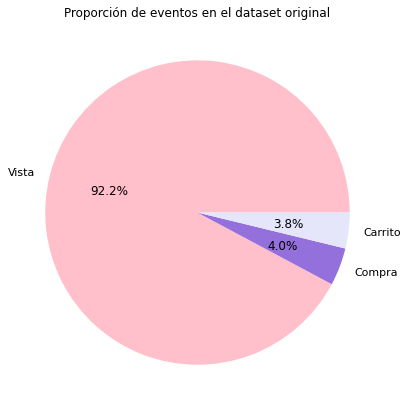

In [113]:
antes_tnulos = [92.2, 4.0, 3.8]
mylabels = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1 = plt.pie(antes_tnulos, labels=mylabels, autopct='%1.1f%%', colors=colors)
plt.title('Proporción de eventos en el dataset original');

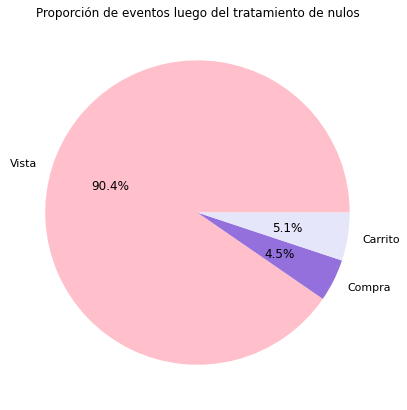

In [115]:
desp_tnulos = [90.4, 4.5, 5.1]
mylabels1 = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1 = plt.pie(desp_tnulos, labels=mylabels1, autopct='%1.1f%%', colors=colors)
plt.title('Proporción de eventos luego del tratamiento de nulos');

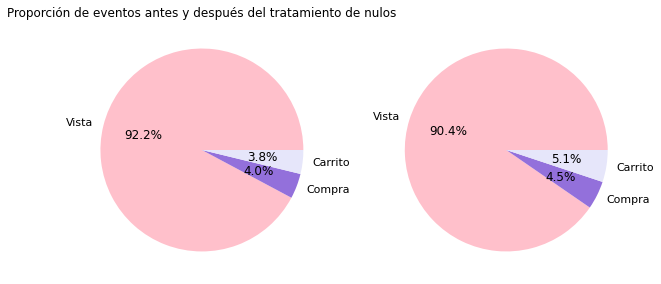

In [124]:
fig, ax =plt.subplots(figsize=(10,10))
antes_tnulos = [92.2, 4.0, 3.8]
mylabels = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']

plt.subplot(1,2,1)
plt.pie(antes_tnulos, labels=mylabels, autopct='%1.1f%%', colors=colors)
plt.title('Proporción de eventos antes y después del tratamiento de nulos');
desp_tnulos = [90.4, 4.5, 5.1]
mylabels1 = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']

plt.subplot(1,2,2)
plt.pie(desp_tnulos, labels=mylabels1, autopct='%1.1f%%', colors=colors);

<ipython-input-55-a277322a4a58>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


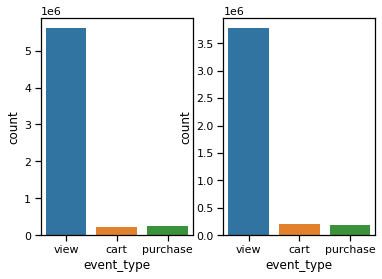

In [55]:
fig, ax =plt.subplots(1,2)
sns.countplot(df["event_type"], ax=ax[0])
sns.countplot(df_preprocessed["event_type"], ax=ax[1])

<AxesSubplot:label='2c504070-dad5-4389-a781-e51ca78ac1df', xlabel='event_type', ylabel='count'>

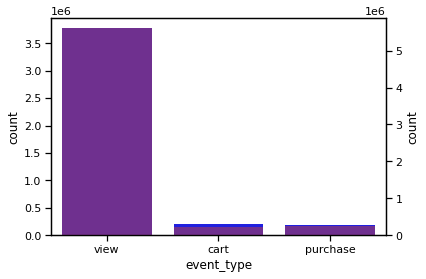

In [81]:
fig,ax=plt.subplots()
sns.countplot(x='event_type',data=df_preprocessed,ax=ax, color='b')
ax2 = ax.twinx()
sns.countplot(x='event_type',data=df, ax=ax2, color='r', alpha=.5, saturation=0.5)

### Eliminar outliers de precios

Antes de comenzar, separamos por categoría con sus correspondientes productos. Primero, se corrobora cuales categorías son más frecuentes (representan al menos 1% del total de los datos) y se clasifica a las demás como 'otros', luego, se buscan outliers de cada categoría.

In [53]:
# método para tratamiento de categorías
def prepare_categories(df, levels=2):
    df_categories = df['category_code'].str.split('.',expand=True)
    if len(df_categories.columns) > levels:
        to_remove = df_categories.columns[levels:]
    df_categories.drop(columns=to_remove,inplace=True) #puedo usar el inplace porque no es global, la estoy definiendo acá
    df = pd.concat([df,df_categories],axis=1)
    df = df.drop(columns='category_code')
    df.columns = ['event_type','product_id','category_id','brand','price', 'user_id','user_session', 'day_of_week',
               'date','time','cat_code','category','product']
    return df

In [54]:
df_preprocessed = prepare_categories(df_preprocessed)

In [55]:
df_preprocessed.head(2)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
39054315,view,1004767,2053013555631882655,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba,Tuesday,2019-10-29,07:06:41,100,electronics,smartphone
24303444,view,1307059,2053013558920217191,apple,1569.920,549727626,022640cb-f45a-4e76-9ade-3eeec65d7837,Friday,2019-10-18,14:21:55,130,computers,notebook


Eliminación de productos gratis

In [56]:
free_prods = df_preprocessed[df_preprocessed['price']==0] # productos gratis
df_preprocessed.drop(free_prods.index, inplace=True)

Búsqueda de productos frecuentes

In [57]:
df_preprocessed['category'].value_counts(normalize=True)


electronics    0.573
appliances     0.173
computers      0.076
apparel        0.047
furniture      0.039
auto           0.034
construction   0.025
kids           0.017
accessories    0.009
sport          0.005
medicine       0.001
country_yard   0.000
stationery     0.000
Name: category, dtype: float64

In [58]:
cat_frecuentes = df_preprocessed['category'].value_counts(normalize=True)[:8].index.to_list()
cat_frecuentes

['electronics',
 'appliances',
 'computers',
 'apparel',
 'furniture',
 'auto',
 'construction',
 'kids']

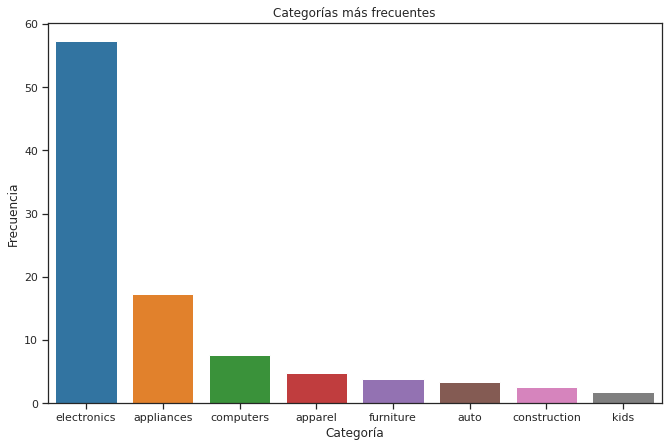

In [59]:
fig,ax = plt.subplots(figsize = (11, 7))
sns.barplot(x=cat_frecuentes, y=df_preprocessed['category'].value_counts(normalize=True)[:8]*100, data=df_preprocessed)
ax.set_title('Categorías más frecuentes')
ax.set(xlabel='Categoría', ylabel='Frecuencia');

In [60]:
df_preprocessed.loc[~(df_preprocessed['category'].isin(cat_frecuentes)),'category'] = 'others'

In [61]:
df_preprocessed['category'].value_counts(normalize=True)

electronics    0.573
appliances     0.173
computers      0.076
apparel        0.047
furniture      0.039
auto           0.034
construction   0.025
kids           0.017
others         0.015
Name: category, dtype: float64

[Text(0, 0.5, 'Frecuencia'), Text(0.5, 0, 'Categoría')]

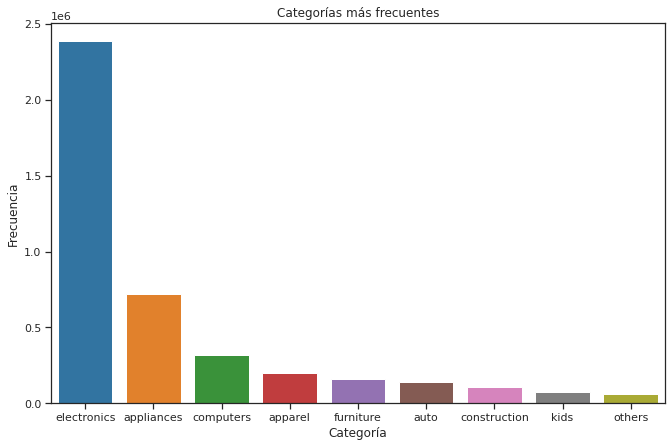

In [62]:
fig,ax = plt.subplots(figsize = (11, 7))
sns.countplot(x='category', order = df_preprocessed['category'].value_counts().index, data=df_preprocessed)
ax.set_title('Categorías más frecuentes')
ax.set(xlabel='Categoría', ylabel='Frecuencia')


In [65]:
def check_outliers(category, umbral=1.5):
    price_category = df_preprocessed.loc[df_preprocessed['category']==category, 'price']
    Q1 = price_category.quantile(0.25)
    Q3 = price_category.quantile(0.75)
    IQR = Q3 - Q1
    umbral_outlier = IQR * umbral
    valor_absoluto_outliers_superior = (price_category > umbral_outlier).sum()
    valor_absoluto_outliers_inferior = (price_category < umbral_outlier*-1).sum()
    valor_relativo_outliers_superior = valor_absoluto_outliers_superior / len(price_category)
    valor_relativo_outliers_inferior = valor_absoluto_outliers_inferior / len(price_category)
    metricas = {'v_a_s':valor_absoluto_outliers_superior,'v_r_s':valor_relativo_outliers_superior,
                'v_a_i':valor_absoluto_outliers_inferior,'v_r_i':valor_relativo_outliers_inferior}
    return metricas

In [66]:
check_outliers('electronics')

{'v_a_i': 0, 'v_a_s': 541136, 'v_r_i': 0.0, 'v_r_s': 0.22651701045902328}

In [67]:
price_category = df_preprocessed.loc[df_preprocessed['category']=='electronics', 'price']

In [68]:
price_category.quantile(0.75)

534.38

In [69]:
umbrales = np.array([1,2,3,4,5,6,7,8,9])
umbrales = pd.DataFrame(umbrales)

In [70]:
newdf = df_preprocessed['category'].copy()
newdf = newdf.drop_duplicates()
newdf = newdf.dropna()
newdf.reset_index()

,index,category
0,39054315,electronics
1,24303444,computers
2,27046904,appliances
3,11200334,apparel
4,36883873,construction
5,10457763,furniture
6,28992716,others
7,25974194,kids
8,22255524,auto


In [ ]:
df_preprocessed.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
accessories,37252.000,58.472,72.625,1.860,24.940,43.760,70.790,1717.160
apparel,196575.000,81.855,45.708,3.470,51.220,74.390,104.760,913.790
appliances,721308.000,209.389,237.123,3.350,57.890,134.060,295.750,2574.040
auto,140719.000,138.804,130.301,5.920,64.090,121.240,154.440,2165.760
computers,317266.000,477.434,471.794,1.260,131.830,337.170,680.510,2574.040
construction,105128.000,156.078,216.971,1.020,51.460,90.070,165.410,2571.160
country_yard,1870.000,257.899,196.855,25.100,124.270,228.510,320.190,2426.320
electronics,2388942.000,402.238,392.515,0.880,143.600,247.080,534.380,2574.070
furniture,163112.000,252.226,252.193,2.550,93.180,167.310,334.370,2574.040


In [ ]:
df_preprocessed.groupby('product')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
accessories,140719.000,138.804,130.301,5.920,64.090,121.240,154.440,2165.760
audio,238248.000,117.313,169.170,0.880,33.210,83.630,160.880,2573.810
bag,28996.000,59.394,78.259,1.860,17.990,42.490,76.960,1717.160
bathroom,4038.000,134.074,169.463,5.680,60.080,86.120,133.985,2379.140
bedroom,50545.000,181.872,156.211,2.550,100.360,148.240,208.450,2074.670
belt,413.000,63.160,76.792,15.190,25.740,25.740,52.510,252.520
bicycle,15093.000,389.416,494.840,3.860,115.810,195.630,450.720,2573.810
camera,5988.000,473.094,507.707,6.180,154.410,360.320,534.070,2567.050
carriage,31811.000,189.933,197.160,0.900,82.050,114.740,199.230,1956.270


In [ ]:
menor_siete = df_preprocessed[df_preprocessed['price']<=7]
menor_siete.shape[0]

18205

In [ ]:
lista_me_siete = menor_siete.category_code.unique().tolist()
lista_me_siete

['accessories.bag',
 'kids.toys',
 'computers.components.cooler',
 'electronics.audio.headphone',
 'computers.peripherals.mouse',
 'construction.tools.light',
 'appliances.kitchen.kettle',
 'kids.fmcg.diapers',
 'furniture.bedroom.blanket',
 'computers.desktop',
 'appliances.ironing_board',
 'furniture.bedroom.pillow',
 'computers.peripherals.camera',
 'apparel.shorts',
 'electronics.telephone',
 'computers.peripherals.keyboard',
 'electronics.audio.microphone',
 'stationery.cartrige',
 'computers.components.memory',
 'kids.dolls',
 'appliances.personal.scales',
 'furniture.kitchen.chair',
 'construction.tools.pump',
 'appliances.personal.hair_cutter',
 'apparel.tshirt',
 'appliances.environment.air_conditioner',
 'furniture.universal.light',
 'auto.accessories.anti_freeze',
 'appliances.environment.air_heater',
 'construction.components.faucet',
 'kids.carriage',
 'sport.tennis',
 'electronics.video.tv',
 'apparel.shoes',
 'sport.bicycle',
 'electronics.clocks',
 'electronics.camera.v

In [ ]:
df_menor_siete = df_preprocessed[df_preprocessed['category_code'].isin(lista_me_siete)]

In [ ]:
df_menor_siete.groupby('category_code')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category_code,,,,,,,,
accessories.bag,28996.000,59.394,78.259,1.860,17.990,42.490,76.960,1717.160
apparel.shoes,100053.000,89.518,36.280,6.950,62.810,86.230,113.000,514.560
apparel.shorts,74.000,11.807,6.773,3.860,4.380,11.810,16.090,32.690
apparel.tshirt,2201.000,45.121,31.822,3.470,33.440,41.160,45.020,244.540
appliances.environment.air_conditioner,4854.000,381.985,296.938,5.680,200.750,283.070,434.127,2412.360
appliances.environment.air_heater,24571.000,51.887,66.405,3.350,25.200,37.810,62.420,1740.910
appliances.environment.water_heater,21120.000,107.617,81.070,3.520,84.690,102.880,117.110,2074.210
appliances.ironing_board,6509.000,48.141,45.264,3.860,27.030,38.590,51.450,347.470
appliances.kitchen.kettle,30168.000,38.989,40.772,5.120,17.990,29.880,45.790,552.320




## Analisis multi-variado

In [72]:
smartphone=df_preprocessed[(df_preprocessed['product']=='smartphone') & (df_preprocessed['event_type']=='view') ]
smartphone.head(1)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
39054315,view,1004767,2053013555631882655,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba,Tuesday,2019-10-29,07:06:41,100,electronics,smartphone


In [74]:
view=smartphone['event_type']=='view'
view

39054315    True
41227753    True
42166149    True
19399196    True
36041219    True
            ... 
42448036    True
42448069    True
42448106    True
42448194    True
42448262    True
Name: event_type, Length: 1461173, dtype: bool

In [84]:
smart = df_preprocessed[df_preprocessed['product']=='smartphone']
smart.groupby('day_of_week')['event_type'].value_counts()

day_of_week  event_type
Friday       view          200733
             cart           21355
             purchase       15105
Monday       view          187842
             cart           17908
             purchase       14302
Saturday     view          191774
             cart           19237
             purchase       13802
Sunday       view          197324
             cart           19132
             purchase       14113
Thursday     view          224080
             cart           20791
             purchase       17255
Tuesday      view          229334
             cart           21453
             purchase       17211
Wednesday    view          230086
             cart           21472
             purchase       18110
Name: event_type, dtype: int64

In [ ]:
fig,ax=plt.subplots()

In [90]:
vistas_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100
carrito_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100
compras_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100

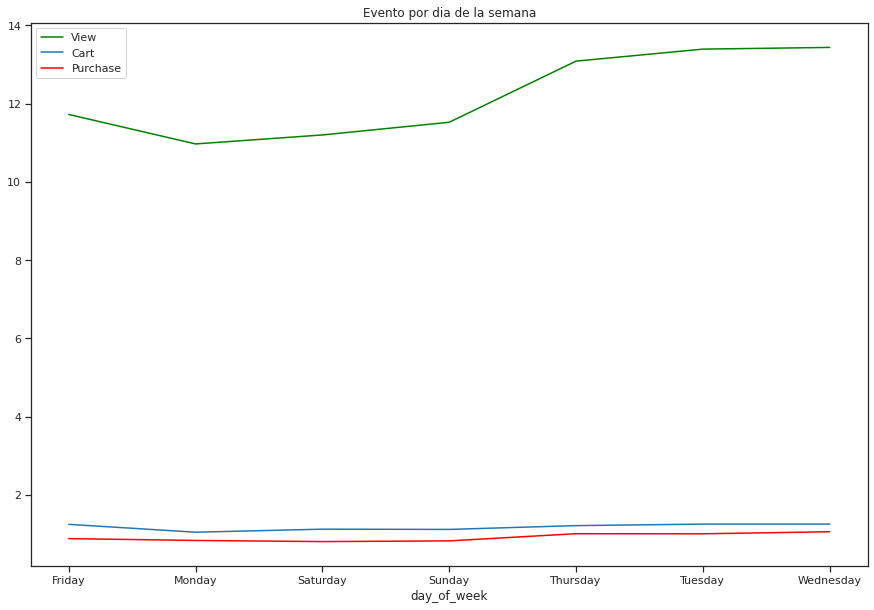

In [91]:
fig,ax=plt.subplots()
vistas_smartp_porc.plot(figsize=(15,10),color='g',label='View')
carrito_smartp_porc.plot(figsize=(15,10),label='Cart')
compras_smartp_porc.plot(figsize=(15,10),color='r',label='Purchase')
plt.title('Evento por dia de la semana')
plt.legend()

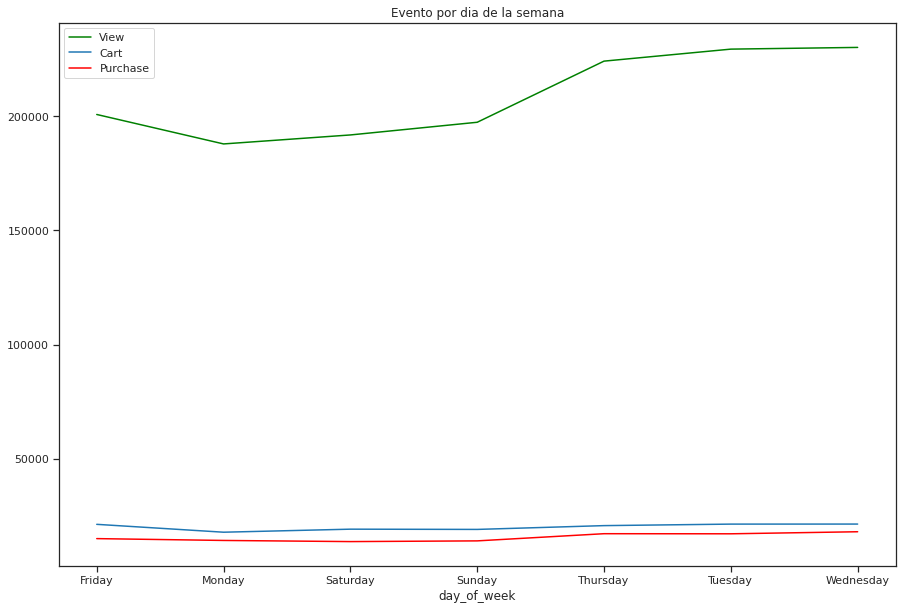

In [85]:
fig,ax=plt.subplots()
df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),color='g',label='View')
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),label='Cart')
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),color='r',label='Purchase')
plt.title('Evento por dia de la semana')
plt.legend()

Text(0.5, 1.0, 'Evento por dia de la semana')

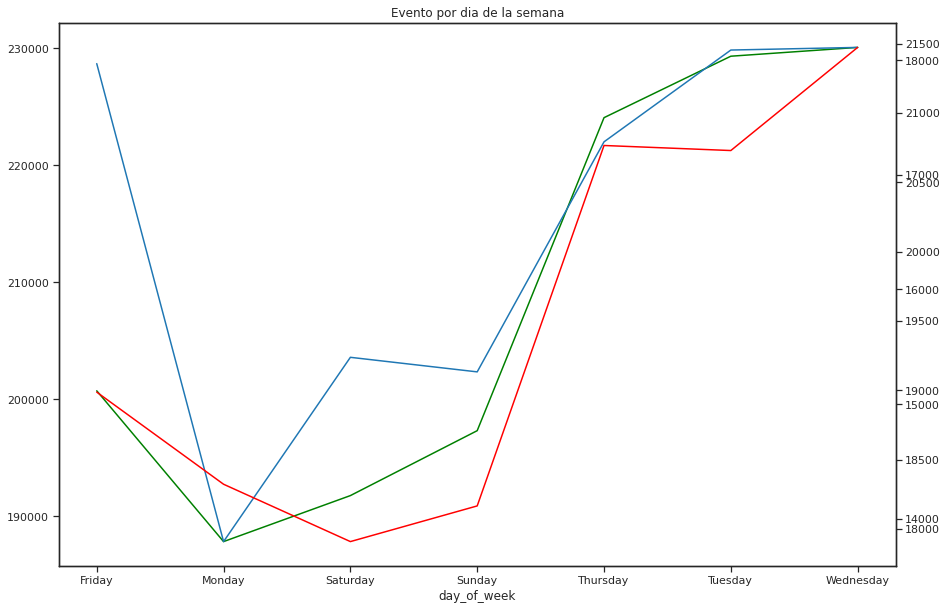

In [93]:
fig,ax=plt.subplots()
df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax,color='g',label='View')
ax2 = ax.twinx()
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax2,label='Cart')
ax3 = ax.twinx()
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax3,color='r',label='Purchase')
plt.title('Evento por dia de la semana')


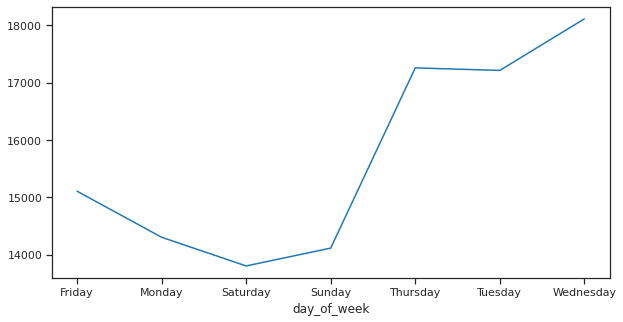

In [76]:
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(10,5))

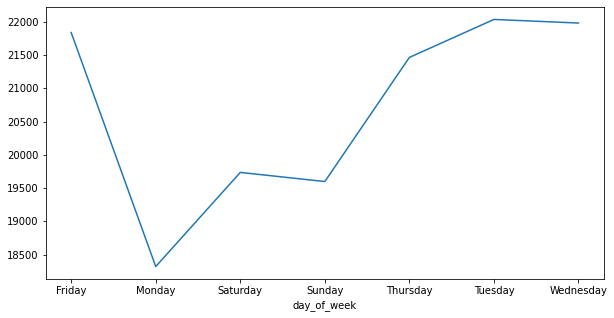

In [ ]:
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(10,5))

In [94]:
df_preprocessed.head(1)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
39054315,view,1004767,2053013555631882655,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba,Tuesday,2019-10-29,07:06:41,100,electronics,smartphone


In [99]:
df_preprocessed['user_session'].nunique()

1616542

In [101]:
df_carpur = df_preprocessed[~(df_preprocessed['event_type']== 'view')].copy()

In [126]:
df_carpur.head(1)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
35358537,cart,1004833,2053013555631882655,samsung,170.140,563310678,b1202966-f49f-4b96-b6c8-8890eb897d42,Saturday,2019-10-26,10:35:42,100,electronics,smartphone


In [139]:
df_carpur.shape

(400941, 13)

In [115]:
df_carpur.groupby('user_session')['event_type'].value_counts()

user_session                          event_type
000001fd-1f89-45e8-a3ce-fe3218cabfad  cart          4
                                      purchase      1
00005b76-13ba-4afe-b80d-2f2b337d3e92  purchase      2
000081ea-9376-4eb8-a69b-0b592765a21d  cart          1
                                      purchase      1
                                                   ..
fffe8505-f670-4750-a4cf-3ca24196f316  purchase      1
ffff3f80-9db8-451e-8ee1-65bd1401283c  cart          1
                                      purchase      1
ffffa654-87e2-3a83-1a87-33c0480c3e36  cart          1
                                      purchase      1
Name: event_type, Length: 304322, dtype: int64

In [118]:
abandono = pd.crosstab(df_carpur['user_session'],df_preprocessed['event_type'])
abandono

event_type,cart,purchase
user_session,,
000001fd-1f89-45e8-a3ce-fe3218cabfad,4,1
00005b76-13ba-4afe-b80d-2f2b337d3e92,0,2
000081ea-9376-4eb8-a69b-0b592765a21d,1,1
0000be48-eb0e-43e6-8b78-25f8bd078926,0,1
0000de39-dc74-414d-8da6-83ad56135bf5,4,4
...,...,...
fffe37ac-daef-4b95-adea-2c3fc53d8832,0,1
fffe5985-76da-4a0b-8f17-8e225efa4142,2,1
fffe8505-f670-4750-a4cf-3ca24196f316,2,1


In [120]:
(abandono['purchase']==0).sum()

61629

In [125]:
abandono[abandono['purchase']==0]

event_type,cart,purchase
user_session,,
00029324-8160-401d-9862-437c547972c8,1,0
0002d833-2a89-40a9-b38d-b91ef248574c,1,0
0004974b-37a8-4c85-93d1-5730a7e2ba55,1,0
00066553-b673-466d-ab7a-15befe527b4f,1,0
00069198-c908-4b6e-83d5-8c8292d327ad,1,0
...,...,...
fff7eb93-c543-4176-bcb5-74ff6cee1c94,1,0
fff7fbe0-7d49-449b-8fdf-fd8f59c5e2ac,1,0
fffb043a-c335-4900-a259-a6b9a6f703de,1,0


In [129]:
sesion_abandono = abandono[abandono['purchase']==0].index.to_list()

In [143]:
len(sesion_abandono)

61629

In [144]:
df_carpur[df_carpur['user_session'].isin(sesion_abandono)].head(1)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
35358537,cart,1004833,2053013555631882655,samsung,170.140,563310678,b1202966-f49f-4b96-b6c8-8890eb897d42,Saturday,2019-10-26,10:35:42,100,electronics,smartphone


In [150]:
abandonadores = df_carpur[df_carpur['user_session'].isin(sesion_abandono)]['user_id'].nunique()
abandonadores

48100

In [147]:
df_car = df_preprocessed[(df_preprocessed['event_type'] == 'cart')].copy()

In [152]:
total_carritos = df_car['user_id'].nunique()
total_carritos

83917

In [153]:
# porcentaje de abandono de carritos
abandonadores/total_carritos*100

57.31854093926141

In [123]:
# (abandono['cart']==1).sum()

102864

In [ ]:
df_preprocessed[df_preprocessed['price'] >= 1900]['category_code'].unique()

array(['computers.peripherals.printer', 'electronics.clocks',
       'computers.desktop', 'electronics.tablet',
       'electronics.smartphone', 'computers.notebook',
       'electronics.audio.acoustic', 'sport.bicycle',
       'furniture.kitchen.table', 'electronics.video.tv',
       'appliances.kitchen.oven', 'appliances.kitchen.washer',
       'appliances.kitchen.coffee_machine', 'kids.carriage',
       'appliances.environment.air_conditioner',
       'furniture.living_room.cabinet', 'construction.tools.generator',
       'construction.tools.pump', 'computers.peripherals.monitor',
       'computers.components.videocards', 'furniture.living_room.sofa',
       'electronics.camera.video', 'electronics.audio.music_tools.piano',
       'appliances.kitchen.refrigerators', 'electronics.video.projector',
       'sport.trainer', 'appliances.iron',
       'appliances.kitchen.steam_cooker', 'appliances.sewing_machine',
       'furniture.bathroom.toilet', 'electronics.camera.photo',
       'kid